In [1]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines, numpy as np, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

import root_pandas,glob

import gc

import uproot
def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='images'

import misc_util#correlation_plots

import R2h_module
import imp
imp.reload(R2h_module)

import mplhep as hep
hep.style.use("CMS")

/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [217]:
df = root_pandas.read_root("/data/sebouh/eg2/python/out_D_C.root")

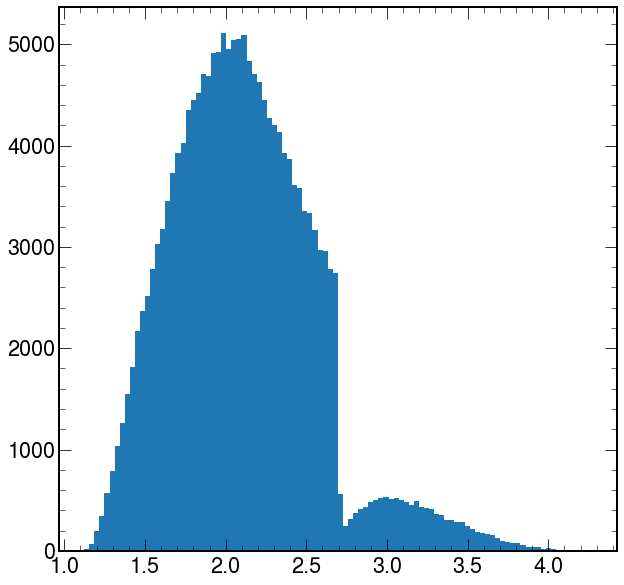

In [218]:
plt.hist(df.query("h_pid==211").query("h_z>0.5").eval("sqrt((h_z*nu)**2-0.13957**2)"),bins=100)
plt.show()

In [219]:
df.eval('h_e = h_z*nu', inplace=True)
df.eval('h_p = sqrt(h_e**2-0.13957**2)', inplace=True)
if max(df.eval("h_th"))<np.pi:
    df.eval(f'h_thd=h_th*{180/np.pi}', inplace=True)
else :
    df.eval(f'h_thd=h_th', inplace=True)
df.eval("h_px=h_p*cos(h_ph)*sin(h_th)", inplace=True)
df.eval("h_py=h_p*sin(h_ph)*sin(h_th)", inplace=True)
df.eval("h_pz=h_p*cos(h_th)", inplace=True)

df.eval("e_px=e_p*cos(e_ph)*sin(e_th)", inplace=True)
df.eval("e_py=e_p*sin(e_ph)*sin(e_th)", inplace=True)
df.eval("e_pz=e_p*cos(e_th)", inplace=True)
df.eval("q_x=-e_px", inplace=True)
df.eval("q_y=-e_py", inplace=True)
df.eval("q_z=-e_pz+5.014", inplace=True)
df.eval("q=sqrt(q_x**2+q_y**2+q_z**2)", inplace=True)
df.eval("l_x=q_x/q", inplace=True)
df.eval("l_y=q_y/q", inplace=True)
df.eval("l_z=q_z/q", inplace=True)


df.eval('inelasticity = nu/5.014', inplace=True)
df = df.query("nu>2.2 and nu<4.2 and Q2>1.0 and Q2<4.0 and inelasticity<0.85")



In [220]:
q1= "h_pid==211"
q1+= " and h_thd>10"
q1+= " and h_z>0.5"

p_thr=2.7
#Nphe_thr=15
Nphe_thr=5
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

q1+= " and "+ trigger_cut_nom.replace("h1_", "h_").replace("h_FidCutPiPlus", "h_FidCut")

df1=df.query(q1)

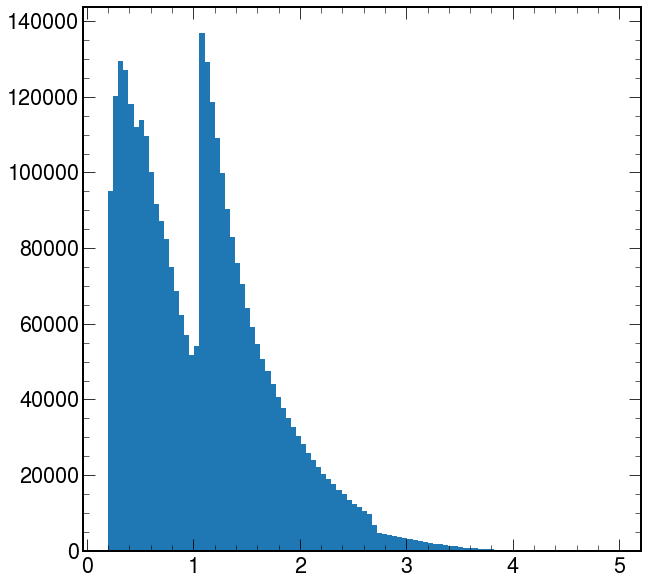

In [221]:
plt.hist(df.eval("sqrt((h_z*nu)**2-0.13957**2)"),bins=100)
plt.show()

In [222]:
q2= "h_pid==-211"
q2+= " and h_p>.350"
q2 += " and ((h_thd>25 and h_p>0.7) or (h_p>0.5 and h_thd>30) or (h_thd>40))" 

trigger_cut_nom   =" abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1"

q2+= " and "+ trigger_cut_nom.replace("h1_", "h_").replace("h_FidCutPiPlus", "h_FidCut")

q2+= " and h_z<0.5 and h_cm_pt>0.25"

df2=df.query(q2)

In [223]:
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

In [224]:
def calc_dphi(df1,df2,i,j):
    l_x=df1.l_x[i]
    l_y=df1.l_y[i]
    l_z=df1.l_z[i]
    
    l_t=np.hypot(l_x, l_y)
    
    s_x =-l_z*l_x/l_t
    s_y =-l_z*l_y/l_t
    s_z = l_t
    
    
    n_x=l_y*s_z-l_z*s_y
    n_y=l_z*s_x-l_x*s_z
    n_z=l_x*s_y-l_y*s_x
    
    h1x=df1.h_px[i]
    h1y=df1.h_py[i]
    h1z=df1.h_pz[i]
    
    h2x=df2.h_px[j]
    h2y=df2.h_py[j]
    h2z=df2.h_pz[j]
    
    phi1 = np.arctan2(h1x*n_x+h1y*n_y+h1z*n_z, h1x*s_x+h1y*s_y+h1z*s_z)
    phi2 = np.arctan2(h2x*n_x+h2y*n_y+h2z*n_z, h2x*s_x+h2y*s_y+h2z*s_z)
    dphi= phi1-phi2
    if dphi>np.pi:
        dphi -= 2*np.pi
    if dphi<-np.pi:
        dphi += 2*np.pi
    return dphi

In [225]:
d={}
d['dphi']=[]
for k in df.keys():
    if "h_" in k:
        d[k.replace("h_","h1_")] = []
        d[k.replace("h_","h2_")] = []
    else :
        d[k] = []
        d[k+"_mixevt"] = []
j=0
for i in range(min(len(df1), 10000)):
    for k in range(10):
        
        dphi=calc_dphi(df1,df2,i,j)
        d['dphi'].append(abs(dphi))
        j+=1
        if j>= len(df2):
            j=0
        for k in df.keys():
            if "h_" in k:
                d[k.replace("h_","h1_")].append(df1[k][i])
                d[k.replace("h_","h2_")].append(df2[k][j])
            else :
                d[k].append(df1[k][i])
                d[k+"_mixevt"].append(df2[k][j])
dfm=pd.DataFrame(d)


In [250]:


df_mc =  root_pandas.read_root("/home/sebouh/CreatePairTuples/MC_Pairs_weighted_C.root","D_C")

#df_mc = root_pandas.read_root("MC_Pairs_D.root","D")

df_mc['h2_truth_p']=df_mc.eval("sqrt((nu_truth*h2_truth_z)**2-.1396**2)")
df_mc['h1_truth_p']=df_mc.eval("sqrt((nu_truth*h1_truth_z)**2-.1396**2)")
cuts = "h1_truth_cm_pt>0.25 and h1_p<2.7"
#cuts += " and h2_truth_cm_pt>0.25"
cuts += " and h2_truth_p>0.35"
cuts += " and h1_truth_z>0.5 and h2_truth_z>0.05 and h2_truth_z<0.45"
cuts += " and h1_truth_pid==211 and h2_truth_cm_pt< 99 and h1_pid==211"
cuts += " and h2_truth_pid==-211 and h1_th>10 and h1_truth_pid==211"
cuts += " and ((h2_truth_th>25 and h2_truth_p>0.7) or (h2_truth_p>0.5 & h2_truth_th>30) or (h2_truth_th>40))"
cuts+=' and abs(h1_truth_th-h1_th)<2'
if "h1_p" not in df_mc.columns:
    df_mc['h1_p'] =df_mc.eval("sqrt((nu*h1_z)**2-.1396**2)")
if "h2_p" not in df_mc.columns:
    df_mc['h2_p'] =df_mc.eval("sqrt((nu*h2_z)**2-.1396**2)")

#df.rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
#df.rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)

#apply trigger cuts.
df_mc= R2h_module.applyCuts(df_mc.query(cuts), nomCuts=True)

Entries before cut  82882
Q2>1.0 and Q2<4.0 82882  (100.00  %)
0.2<h1_p<5.0  82882  (100.00  %)
inelasticity < 0.85 82882  (100.00  %)
h1_pid = pions (trigger) 82882  (100.00  %)
2.2 < nu <4.2 82882  (100.00  %)
10< h1_th 82882  (100.00  %)
Theta/P fiducial region selected for trigger hadron 82882  (100.00  %)
Nom cuts for the trigger applied 67633  (81.60  %)


rms=0.024909401111653153


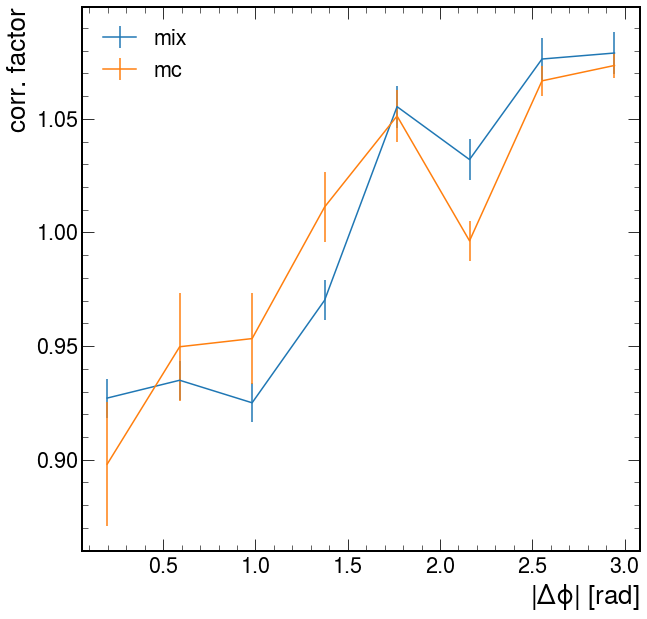

In [251]:
def compare_mc_mix(mix_cuts=None, mc_cuts=None, bins=8):
    df=dfm
    if mix_cuts:
        df = dfm.query(mix_cuts)
    y,x=np.histogram(df.dphi,bins=bins,range=(0,np.pi))
    x=(x[1:]+x[:-1])/2
    dy=np.sqrt(y)*len(y)/sum(y)
    y=y*len(y)/sum(y)
    plt.errorbar(x,y,dy, label="mix")

    weighted=False
    
    df = df_mc.query("h1_p==h1_p")
    if mc_cuts:
        df = df_mc.query(mc_cuts)
        
    df.eval("test=h1_truth_cm_ph-h2_truth_cm_ph", inplace=True)
    df.eval(f"test=test+2*{np.pi}*(test<-{np.pi})-2*{np.pi}*(test>{np.pi})", inplace=True)
    denom,x = np.histogram(df.eval("abs(test)"), bins=np.linspace(0, np.pi, bins+1), weights=df.weight_truth if weighted else None)

    q_pass = "h2_pid==-211 and h2_z>0.05 and h2_z<0.45 and abs(h2_deltaZ)<3 and h2_FidCutPiPlus==1 and h2_cm_pt<99"
    q_pass += " and abs(h2_th-h2_truth_th)<2 and h2_cm_pt>0.25"

    dfpass = df.query(q_pass)
    num,x = np.histogram(dfpass.eval("abs(dphi_truth)"), bins=np.linspace(0, np.pi, bins+1), weights=dfpass.weight_truth if weighted else None)
    eff=num/denom
    deff=np.sqrt((num)*(denom-num)/(denom**3))
    x=(x[:-1]+x[1:])/2
    ymc=eff/np.mean(eff)
    dymc = deff/np.mean(eff)
    plt.errorbar(x,ymc,dymc, label="mc")
    print(f"rms={np.sqrt(np.sum((ymc-y)**2)/len(y))}")
    plt.xlabel("$|\Delta\phi|$ [rad]")
    plt.ylabel("corr. factor")
compare_mc_mix(bins=8)
plt.legend()
plt.show()

rms=0.1110681717526734
rms=0.03367474149186902
rms=0.06527719566226767


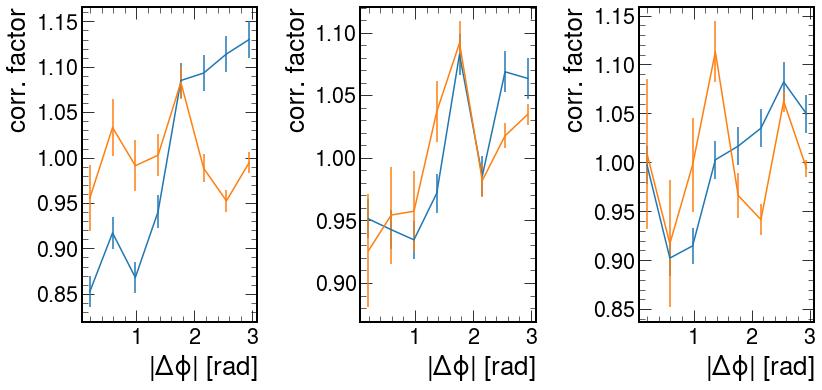

In [249]:
fig, axs = plt.subplots(1,3, figsize=(12,6))
partitions=[0.25, 0.4, 0.6, 1.0]
for i in range(3):
    mn, mx = partitions[i:i+2]
    plt.sca(axs[i])
    compare_mc_mix(f"h1_cm_pt>{mn} and h1_cm_pt<{mx}", f"h1_cm_pt>{mn} and h1_cm_pt<{mx}")
plt.tight_layout()


rms=0.07145705224951006
rms=0.09307412836670094
rms=0.11977805437996174


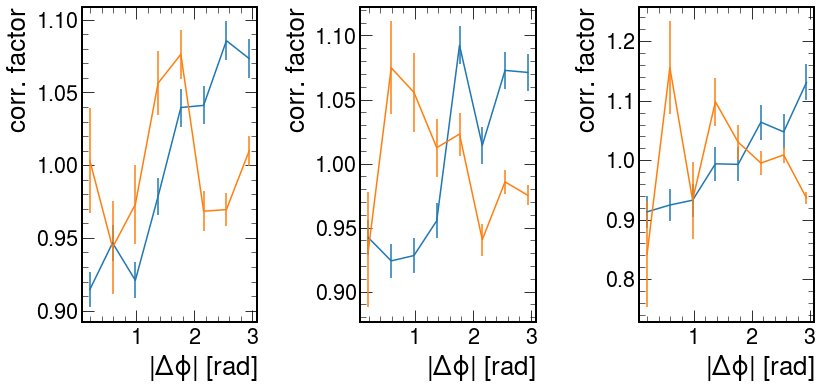

In [246]:
fig, axs = plt.subplots(1,3, figsize=(12,6))
partitions=[0.25, 0.4, 0.6, 0.8]
for i in range(3):
    mn, mx = partitions[i:i+2]
    plt.sca(axs[i])
    compare_mc_mix(f"h2_cm_pt>{mn} and h2_cm_pt<{mx}", f"h2_truth_cm_pt>{mn} and h2_truth_cm_pt<{mx}")
plt.tight_layout()

rms=0.10886116129860736
rms=nan
rms=nan
rms=nan


<ipython-input-94-25bb1f0e3b7e>:7: RuntimeWarning: invalid value encountered in true_divide
  dy=np.sqrt(y)*len(y)/sum(y)
<ipython-input-94-25bb1f0e3b7e>:8: RuntimeWarning: invalid value encountered in true_divide
  y=y*len(y)/sum(y)
/home/sebouh/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-94-25bb1f0e3b7e>:7: RuntimeWarning: invalid value encountered in true_divide
  dy=np.sqrt(y)*len(y)/sum(y)
<ipython-input-94-25bb1f0e3b7e>:8: RuntimeWarning: invalid value encountered in true_divide
  y=y*len(y)/sum(y)
/home/sebouh/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-94-25bb1f0e3b7e>:7: RuntimeWarning: invalid value encountered in true_divide
  dy=np.sqrt(y)*len(y)/sum(y)
<ipython-input-94-25bb1f0e3b7e>:8: RuntimeWa

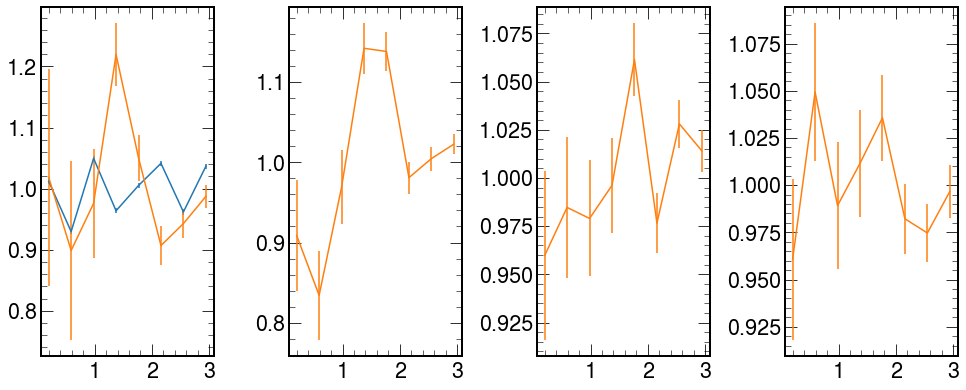

In [102]:
fig, axs = plt.subplots(1,4, figsize=(14,6))
partitions=[0, 0.5, 1.0, 1.5, 2.0]
for i in range(4):
    mn, mx = partitions[i:i+2]
    plt.sca(axs[i])
    compare_mc_mix(f"h1_cm_rap-h2_cm_rap>{mn} and h1_cm_rap-h2_cm_rap<{mx}", f"drap_truth>{mn} and drap_truth<{mx}")
plt.tight_layout()

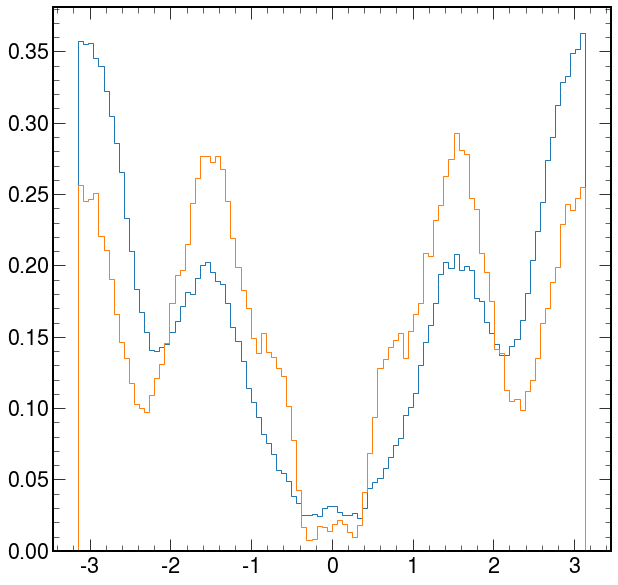

In [216]:
plt.hist(df1.eval("h_cm_ph"), bins=100, density=True, histtype='step')
plt.hist(df_mc.eval("h1_cm_ph"), bins=100, density=True, histtype='step')
plt.show()

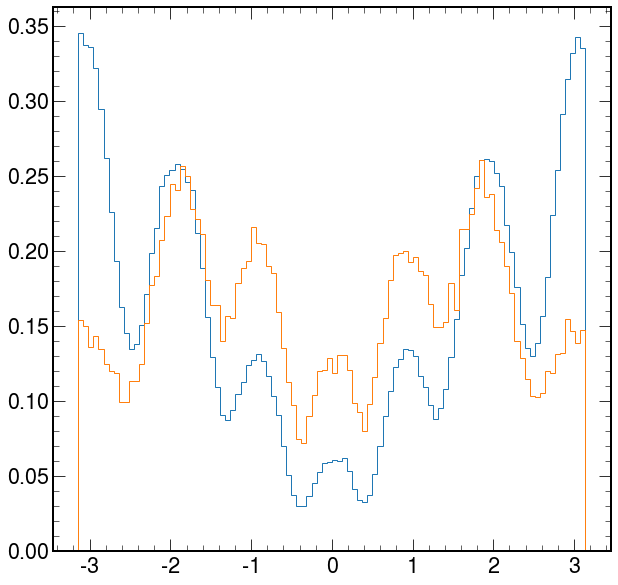

In [215]:
plt.hist(df2.eval("h_cm_ph"), bins=100, density=True, histtype='step')
plt.hist(df_mc.query("pass_recon==1").eval("h2_cm_ph"), bins=100, density=True, histtype='step')
plt.show()

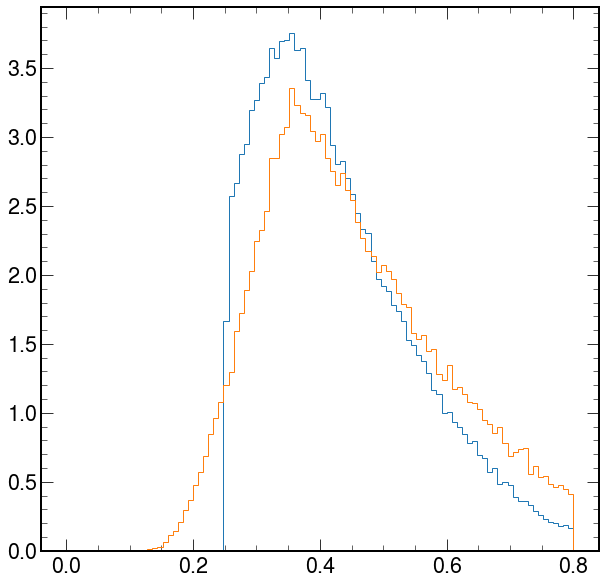

In [241]:
plt.hist(dfm.eval("h2_cm_pt"), bins=100, density=True, histtype='step',range=(0, 0.8))
plt.hist(df_mc.eval("h2_truth_cm_pt"), bins=100, density=True, histtype='step', range=(0, 0.8))
plt.show()

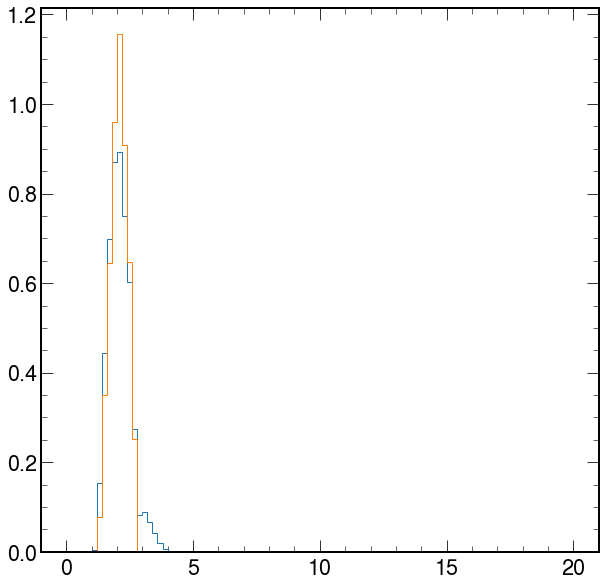

In [213]:
plt.hist(df1.eval("h_p"), bins=100, density=True, histtype='step',range=(0, 20))
plt.hist(df_mc.eval("h1_truth_p"), bins=100, density=True, histtype='step', range=(0,20))
plt.show()

(array([1.000e+00, 1.400e+01, 3.400e+01, 9.200e+01, 1.600e+02, 2.980e+02,
        4.320e+02, 5.850e+02, 8.080e+02, 9.910e+02, 1.188e+03, 1.496e+03,
        1.735e+03, 1.986e+03, 2.207e+03, 2.540e+03, 2.654e+03, 2.921e+03,
        2.799e+03, 2.747e+03, 2.656e+03, 2.471e+03, 2.415e+03, 2.357e+03,
        2.172e+03, 2.021e+03, 1.896e+03, 1.802e+03, 1.754e+03, 1.653e+03,
        1.582e+03, 1.382e+03, 1.348e+03, 1.253e+03, 1.120e+03, 1.116e+03,
        1.036e+03, 9.750e+02, 9.270e+02, 8.540e+02, 7.690e+02, 7.130e+02,
        6.040e+02, 6.470e+02, 5.580e+02, 5.050e+02, 4.720e+02, 4.150e+02,
        3.790e+02, 3.570e+02, 3.460e+02, 2.910e+02, 3.030e+02, 2.770e+02,
        2.530e+02, 2.120e+02, 1.910e+02, 2.080e+02, 1.670e+02, 1.550e+02,
        1.350e+02, 1.090e+02, 1.290e+02, 9.300e+01, 9.600e+01, 9.100e+01,
        8.700e+01, 6.500e+01, 6.200e+01, 4.800e+01, 4.100e+01, 4.400e+01,
        4.100e+01, 3.400e+01, 3.100e+01, 2.800e+01, 2.200e+01, 2.300e+01,
        1.900e+01, 2.200e+01, 1.200e+0

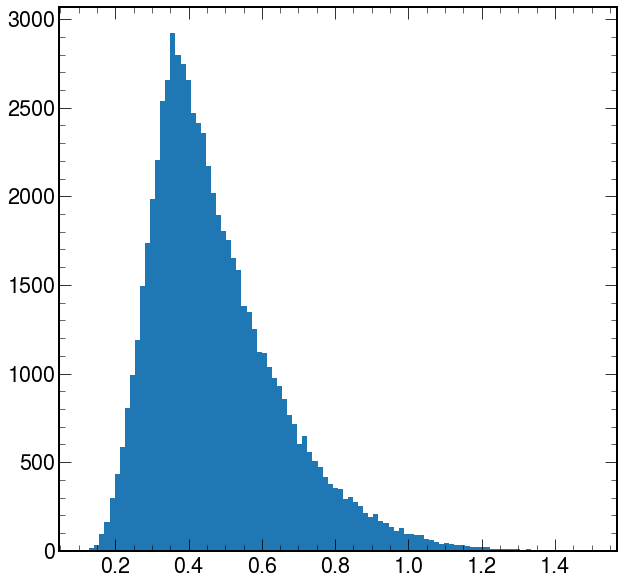

In [242]:
plt.hist(df_mc.eval("h2_truth_cm_pt"), bins=100, )